In [100]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D, Activation, DepthwiseConv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report


## Dataset

In [121]:
# Parameters
NUM_CLASSES = 5
TRAIN_DIR = "C:\\Users\\karim\\OneDrive - uniroma1.it\\Documents\\machine learning\\homework2\\train"
TEST_DIR = "C:\\Users\\karim\\OneDrive - uniroma1.it\\Documents\\machine learning\\homework2\\test"

# Function to load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in os.listdir(data_dir):
        path = os.path.join(data_dir, label)
        if os.path.isdir(path):
            for img_file in os.listdir(path):
                img_path = os.path.join(path, img_file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    #img = cv2.resize(img, (64, 64))
                    data.append(img)
                    labels.append(int(label))  # Assuming the folder name is the label
                except Exception as e:
                    print(f"Error with file {img_path}: {e}")
    return np.array(data), np.array(labels)

# Loading data
X_train_raw, y_train_raw = load_data(TRAIN_DIR)
X_test_raw, y_test_raw = load_data(TEST_DIR)



Count of images for each class in the training set:
Class 0: 1000 images
Class 1: 1500 images
Class 2: 1500 images
Class 3: 2000 images
Class 4: 369 images


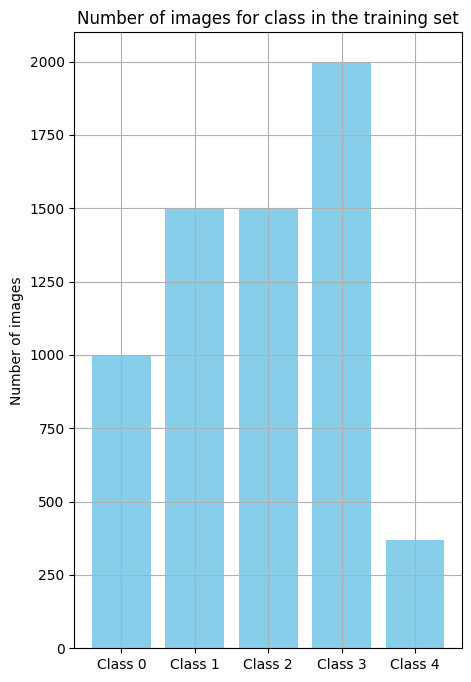


Count of images for each class in the test set:
Class 0: 133 images
Class 1: 275 images
Class 2: 406 images
Class 3: 1896 images
Class 4: 39 images


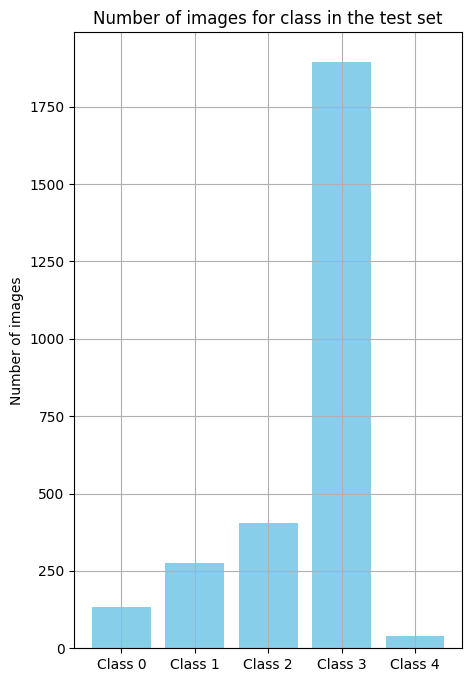

In [122]:
# Count of images per class
unique, counts = np.unique(y_train_raw, return_counts=True)
print("\nCount of images for each class in the training set:")
for label, count in dict(zip(unique, counts)).items():
    print(f"Class {label}: {count} images")  

# Count of images per class in the training set
plt.figure(figsize=(5, 8))
plt.bar(unique, counts, tick_label=[f'Class {i}' for i in unique], color=['skyblue'] * NUM_CLASSES)
plt.ylabel('Number of images')
plt.title('Number of images for class in the training set')
plt.grid(True)  # Add grid
plt.show()

unique, counts = np.unique(y_test_raw, return_counts=True)    
# Count of images per class in the test set
print("\nCount of images for each class in the test set:")
for label, count in dict(zip(unique, counts)).items():
    print(f"Class {label}: {count} images")

# Count of images per class in the test set
plt.figure(figsize=(5, 8))
plt.bar(unique, counts, tick_label=[f'Class {i}' for i in unique], color=['skyblue'] * NUM_CLASSES)
plt.ylabel('Number of images')
plt.title('Number of images for class in the test set')
plt.grid(True)  # Add grid
plt.show()


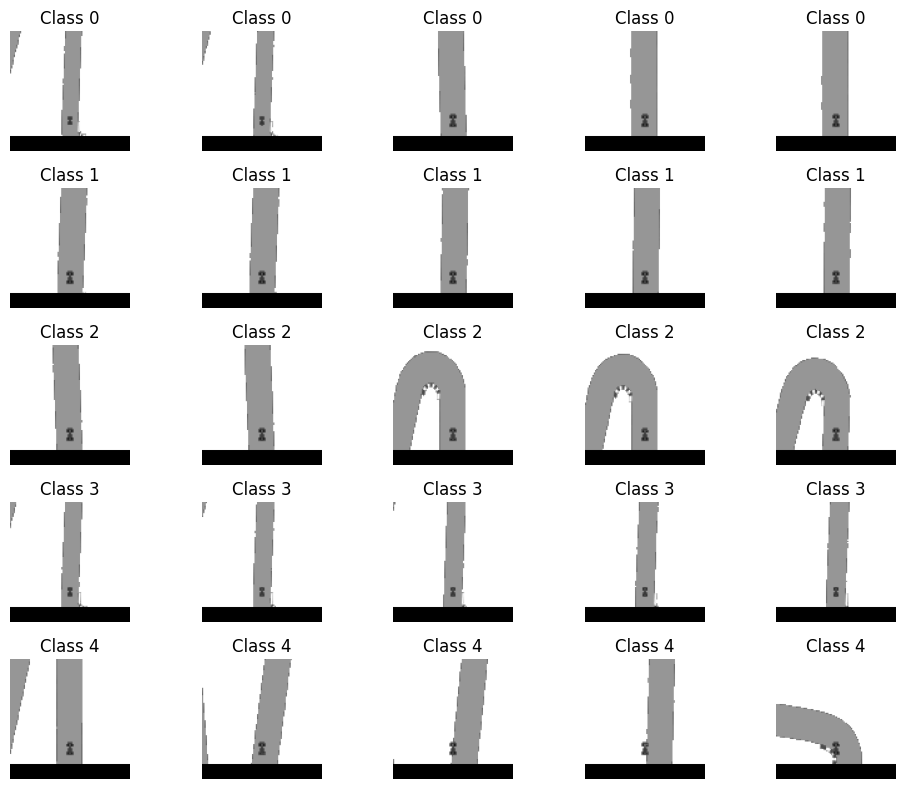

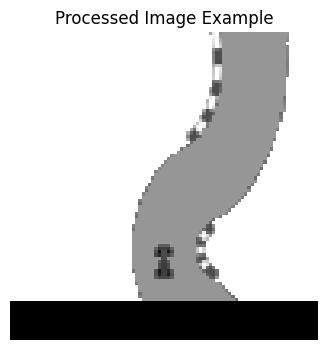

In [144]:
def process_image(img):
    """
    First transforms green pixels to white, then converts the rest to grayscale.

    Args:
        img (numpy.ndarray): Image in RGB format.

    Returns:
        numpy.ndarray: Transformed image.
    """
    # Define the green color range in RGB
    lower_green = np.array([100, 160, 100])  # Minimum value for green
    upper_green = np.array([101, 230, 101])  # Maximum value for green
    # define the gray color range in RGB
    lower_gray = np.array([100, 100, 100])  # Minimum value for gray
    upper_gray = np.array([107, 107, 107])  # Maximum value for gray
    #define the red color range in RGB

    
    # Create a mask for green pixels
    mask_green = cv2.inRange(img, lower_green, upper_green)
    # Create a mask for gray pixels
    mask_gray = cv2.inRange(img, lower_gray, upper_gray)
    # Transform green pixels to white
    img[mask_green > 0] = [255, 255, 255]
    # Transform gray pixels to  uniform color
    img[mask_gray > 0] = [100, 160, 100]

    # Convert the entire image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Convert the grayscale image to RGB to return the image with 3 channels
    gray_img_rgb = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    # Set the bottom rectangle (height 12 and width 96) to black
    gray_img_rgb[84:96, 0:96] = [0, 0, 0]
    return gray_img_rgb


# Function to apply a transformation to the images
def transform_images(images):
    transformed_images = []
    for img in images:
        transformed_img = process_image(img)  # Use the process_image function defined earlier
        transformed_images.append(transformed_img)
    return np.array(transformed_images)


# Data transformation
X_train = transform_images(X_train_raw)
X_test = transform_images(X_test_raw)

# Visualization of multiple images: for example, 3 examples for each of the 5 classes
plt.figure(figsize=(10, 8))
num_images_per_class = 5
for class_id in range(NUM_CLASSES):
    class_images = X_train[y_train_raw == class_id]
    for i in range(min(num_images_per_class, len(class_images))):
        plt.subplot(NUM_CLASSES, num_images_per_class, class_id * num_images_per_class + i + 1)
        plt.imshow(class_images[i])
        plt.title(f"Class {class_id}")
        plt.axis("off")
plt.tight_layout()
plt.show() 

#visualization of the processed images
plt.figure(figsize=(4, 4))
if len(X_train) > 102:
    plt.imshow(X_train[102])
    plt.title("Processed Image Example")
    plt.axis("off")
    plt.show()
else:
    print("Not enough images to display at index 102.")

# Pixel normalization
X_train = X_train / 255
X_test = X_test / 255

# Conversion to one-hot format
y_train = to_categorical(y_train_raw, NUM_CLASSES)
y_test = to_categorical(y_test_raw, NUM_CLASSES)

Batch di immagini: (32, 96, 96, 3), Batch di etichette: (32, 5)


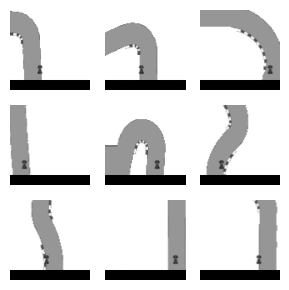

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.4011 - loss: 1.7444 - val_accuracy: 0.6933 - val_loss: 1.2966
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.5034 - loss: 1.2991 - val_accuracy: 0.7148 - val_loss: 1.1063
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5315 - loss: 1.2485 - val_accuracy: 0.6519 - val_loss: 1.0691
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5565 - loss: 1.1945 - val_accuracy: 0.1953 - val_loss: 1.8154
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.5480 - loss: 1.2052 - val_accuracy: 0.7112 - val_loss: 0.9516
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5754 - loss: 1.1638 - val_accuracy: 0.6955 - val_loss: 1.0070
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5357 - loss: 1.1973 - val_accuracy: 0.6624 - val_loss: 1.0323
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5593 - loss: 1.1856 - val

In [149]:
"""
def create_model(input_shape=(96, 96, 3), num_actions=5):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),  # Added layer
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_actions, activation='softmax')
    ])
    return model
"""

def create_model(input_shape=(96, 96, 3), num_actions=5):
    model = Sequential([
        
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_actions, activation='softmax')
    ])
    return model

# Model creation
model = create_model()

# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""
class_weights_dict = {
    0: 1.2738,
    1: 0.8492,
    2: 0.8492,
    3: 0.6369,
    4: 3.4546
}
"""

# Early Stopping configuration
early_stopping = EarlyStopping(
    monitor='val_accuracy',         # Monitor validation accuracy
    patience=10,                    # Stop if no improvement for 10 consecutive epochs
    restore_best_weights=True       # Restore model weights with the best performance
)

# Data Augmentation (limited for this type of images)
datagen = ImageDataGenerator(
    height_shift_range=0.4,
    fill_mode='nearest',
)
datagen.fit(X_train)

# Create the generator
train_generator = datagen.flow(
    X_train,                    # Image dataset
    y_train,                    # Corresponding labels
    batch_size=32               # Number of images per batch
)

# Verify it works
for X_batch, y_batch in train_generator:
    print(f"Batch of images: {X_batch.shape}, Batch of labels: {y_batch.shape}")
    break  # To see only the first batch

# Plotting images generated with data augmentation
plt.figure(figsize=(3, 3))
for X_batch, y_batch in train_generator:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    break  # Only plot the first batch
plt.tight_layout()
plt.show()

# Model training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")


In [150]:
# Salvataggio del modello
model.save('my_model.h5')
print("Modello salvato con successo in 'my_model.h5'")


Modello salvato con successo in 'my_model.h5'


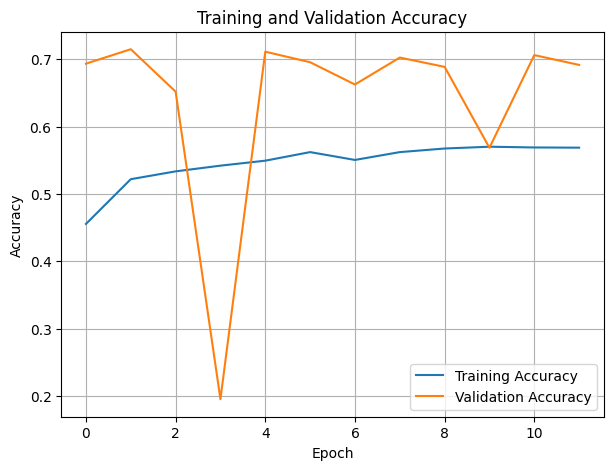

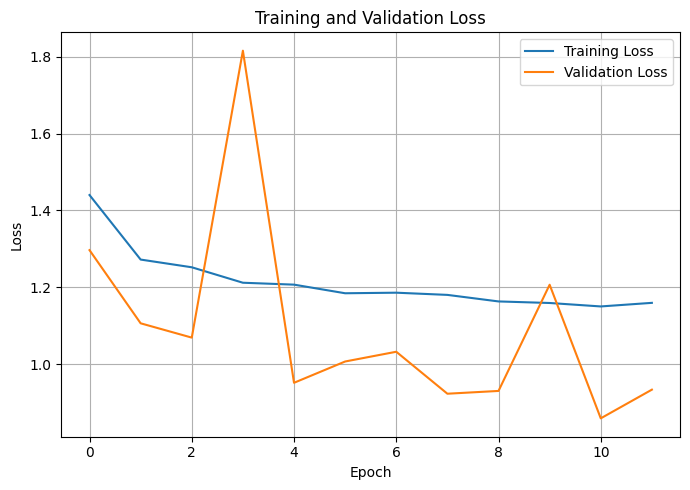

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


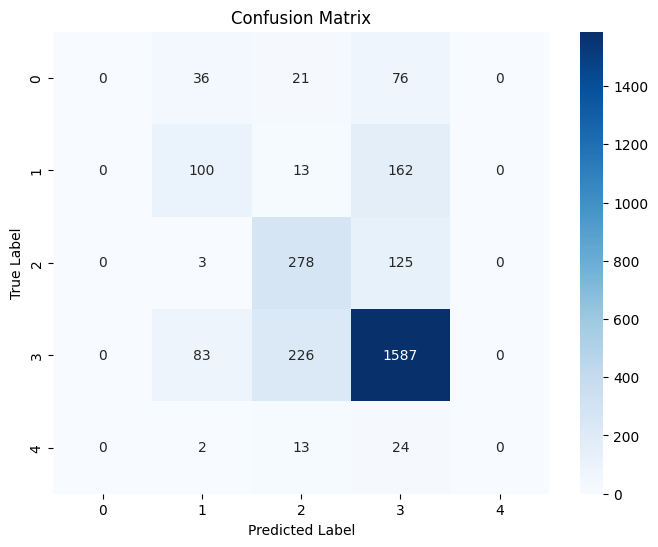

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.45      0.36      0.40       275
           2       0.50      0.68      0.58       406
           3       0.80      0.84      0.82      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.71      2749
   macro avg       0.35      0.38      0.36      2749
weighted avg       0.67      0.71      0.69      2749



c:\Users\karim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\karim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\karim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

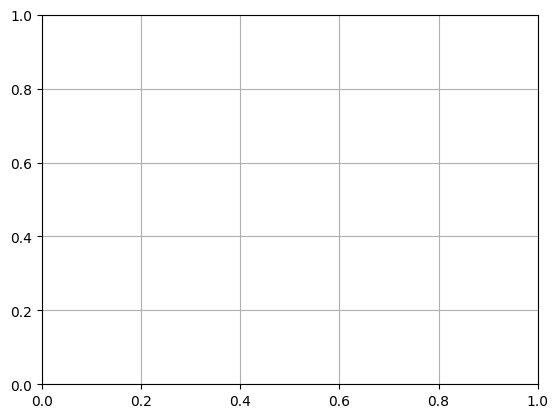

In [165]:
# Visualizzazione dei risultati
# Grafici di accuratezza e loss
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Matrice di confusione
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.grid(True)
# Report di classificazione
print(classification_report(y_true, y_pred_classes))
